In [2]:
import numpy as np 
import cPickle as pkl
from matplotlib import pyplot as plt

import theano_time_corex
import linearcorex

import sklearn.covariance as skcov
from sklearn.decomposition import FactorAnalysis, PCA

from generate_data import generate_nglf_from_matrix, generate_nglf_from_model

from sklearn.preprocessing import StandardScaler

import sys

import vis_utils
import metric_utils

# Generate Data

In [3]:
nt = 10
m = 8
bs = 16  # bs = 64
nv = m * bs
train_cnt = 8
test_cnt = 100

snr = 5.0
min_var = 1.0
max_var = 1.0

(data1, sigma1) = generate_nglf_from_model(nv, m, nt // 2, ns=train_cnt + test_cnt, snr=snr, min_var=min_var, max_var=max_var)
(data2, sigma2) = generate_nglf_from_model(nv, m, nt // 2, ns=train_cnt + test_cnt, snr=snr, min_var=min_var, max_var=max_var)

data = data1 + data2
ground_truth = [sigma1 for i in range(nt // 2)] + [sigma2 for i in range(nt // 2)]

X = [x[:train_cnt] for x in data]
Y = [x[train_cnt:] for x in data]

Fixed SNR: 5.0
Fixed SNR: 5.0


## save the data 

In [3]:
all_data = {
    'nt': nt,
    'm': m,
    'bs': bs,
    'nv': nv,
    'train_cnt': train_cnt,
    'test_cnt': test_cnt,
    'X': X,
    'ground_truth': ground_truth,
    'Y': Y,
    'snr': 5.0,
    'min_var': min_var,
    'max_var': max_var,
}
with open("saved_data/synthetic-buckets-nglf.nt{}.nv{}.m{}.ns{}.pkl".format(nt, nv, m, train_cnt), 'wb') as f:
    pkl.dump(all_data, f)

### Ground Truth Covariance 

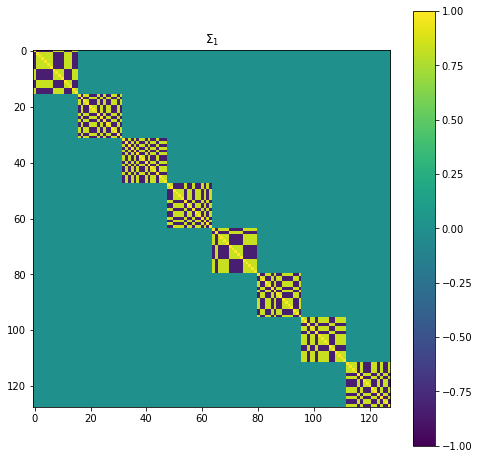

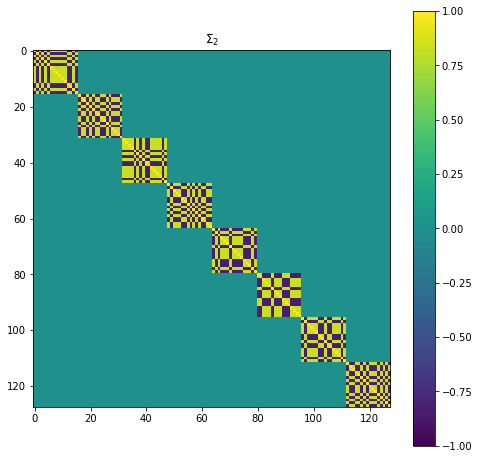

In [4]:
if ground_truth[0] is not None:
    vis_utils.plot_cov_matrix(sigma1, title='$\Sigma_1$')
    vis_utils.plot_cov_matrix(sigma2, title='$\Sigma_2$')

#### Sample covariance matrix using train/test data

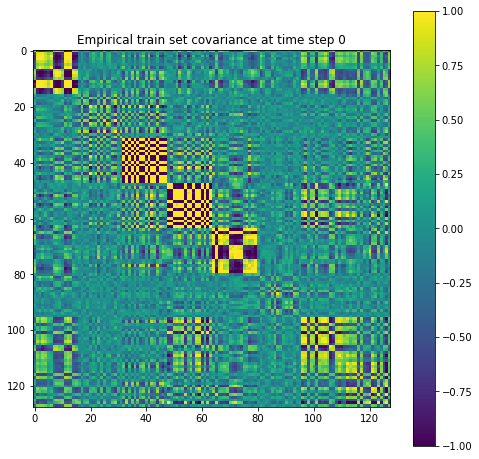

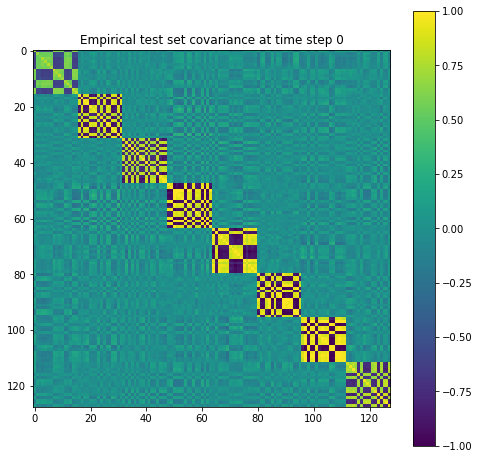

In [6]:
vis_utils.plot_cov_matrix(np.cov(X[0].T), title="Empirical train set covariance at time step 0")
vis_utils.plot_cov_matrix(np.cov(Y[0].T), title="Empirical test set covariance at time step 0")

## utils

In [7]:
def calc_reg_term(covs, metric='l1'):
    plt.figure(figsize=(6,6))
    ans = []
    for t in range(nt-1):
        if metric == 'l1':
            ans.append(np.mean(np.abs(covs[t] - covs[t+1])))
        if metric == 'l2':
            ans.append(np.mean(np.square(covs[t] - covs[t+1])))
    
    plt.bar(range(nt-1), ans)
    plt.show()
    return np.mean(ans)

# Ground Truth Statistics

#### This graph shows how well the covariance at timestep t models the test data at timestep t+1. Clearly we should see a peak at the middle timestep.

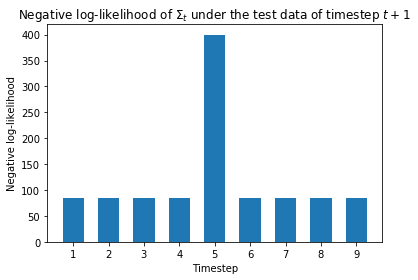

NLL for next time step = 119.536184676


In [8]:
if ground_truth[0] is not None:
    vis_utils.plot_for_next_timestep(data=Y, covs=ground_truth, title="Negative log-likelihood of $\Sigma_t$ under the test data of timestep $t + 1$")

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [9]:
if ground_truth[0] is not None:
    print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=ground_truth))

Final NLL = 84.6080429684


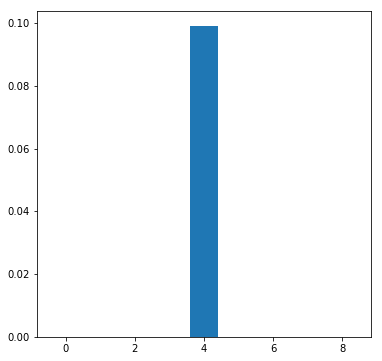

0.0110089337384


In [10]:
print calc_reg_term(ground_truth)

# Learn independent linear corexes on each timestep

In [11]:
cs = []
for x in X:
    c = linearcorex.Corex(n_hidden=m,
                          max_iter=500,
                          anneal=True)
    c.fit(x)
    cs.append(c)
    
print sum([c.tc for c in cs])

1422.59909821


In [12]:
cs_covs = [c.get_covariance() for c in cs]

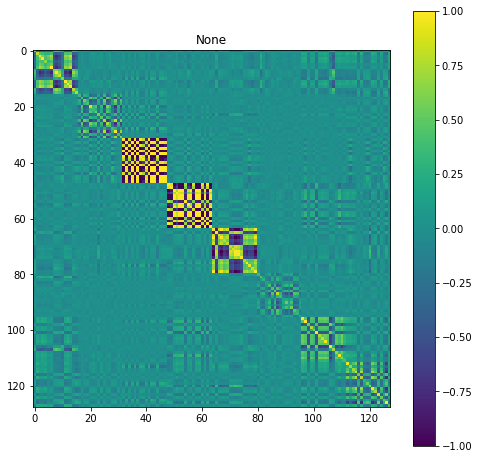

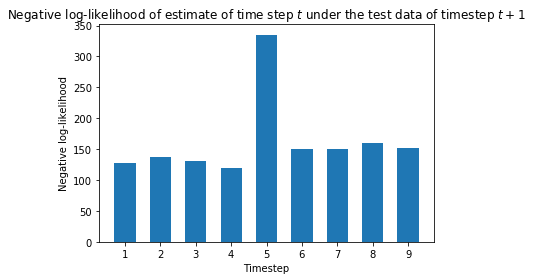

NLL for next time step = 162.628892402


In [13]:
vis_utils.plot_cov_matrix(cs_covs[0])
vis_utils.plot_for_next_timestep(data=Y, covs=cs_covs);

In [14]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=cs_covs))

Final NLL = 145.876708963


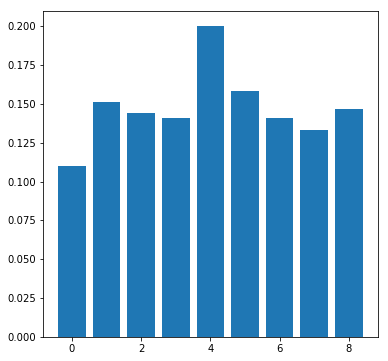

0.147324


In [15]:
print calc_reg_term(cs_covs)

# L1 regularization on the difference of neighbouring covariance estimates

In [101]:
best_nll = np.inf
best_csig = None
best_l1 = None
coefs = [0, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
coefs=[5000]
nlls = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                            nv=nv,
                                            n_hidden=m,
                                            max_iter=500,
                                            verbose=False,
                                            anneal=True,
                                            l1=l1)
    csig.fit(X)
    csig_covs = csig.get_covariance()
    nll = metric_utils.calculate_nll_score(data=Y, covs=csig_covs)
    nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_csig = csig
        best_l1 = l1

print "best l1 = {}".format(best_l1)
csig = best_csig
print sum(csig.tc)

training with l1 = 5000
Annealing iteration finished, time = 2.92253303528
Annealing iteration finished, time = 2.96231412888
Annealing iteration finished, time = 2.94691991806
Annealing iteration finished, time = 2.91425013542
Annealing iteration finished, time = 3.02071285248
Annealing iteration finished, time = 2.99538803101
Annealing iteration finished, time = 2.94626808167
l1 = 5000, nll = 193.905796148
best l1 = 5000
111.020829792


In [102]:
csig_covs = csig.get_covariance()

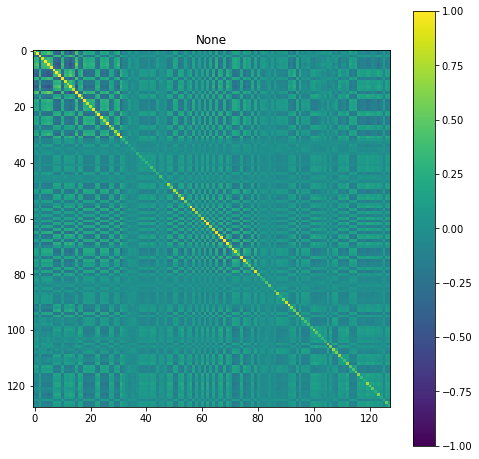

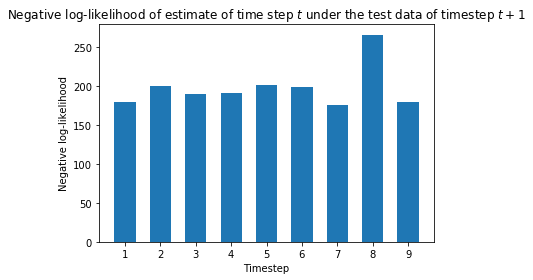

NLL for next time step = 197.976359353


In [103]:
vis_utils.plot_cov_matrix(csig_covs[0])
vis_utils.plot_for_next_timestep(data=Y, covs=csig_covs);

In [104]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=csig_covs))

Final NLL = 193.905796148


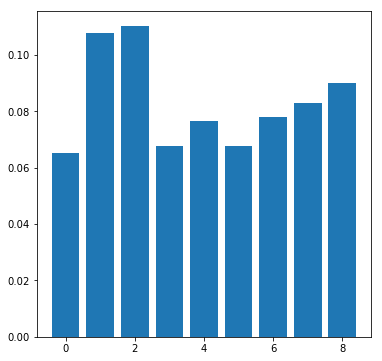

0.0829584206493


In [105]:
print calc_reg_term(csig_covs)

# Linear CorEx W regularization

In [55]:
best_nll = np.inf
best_csig = None
best_l1 = None
coefs = [0, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
coefs=[0.3]
nlls = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    csig = theano_time_corex.TimeCorexW(nt=nt,
                                        nv=nv,
                                        n_hidden=m,
                                        max_iter=500,
                                        verbose=False,
                                        anneal=True,
                                        l1=l1)
    csig.fit(X)
    csig_covs = csig.get_covariance()
    nll = metric_utils.calculate_nll_score(data=Y, covs=csig_covs)
    nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_csig = csig
        best_l1 = l1

print "best l1 = {}".format(best_l1)
csig = best_csig
print sum(csig.tc)

training with l1 = 0.3
Annealing iteration finished, time = 1.39038801193
Annealing iteration finished, time = 1.39852786064
Annealing iteration finished, time = 1.40523886681
Annealing iteration finished, time = 1.39973783493
Annealing iteration finished, time = 1.39512205124
Annealing iteration finished, time = 1.40218496323
Annealing iteration finished, time = 1.38934588432
l1 = 0.3, nll = 142.05298357
best l1 = 0.3
1287.58206767


In [56]:
csig_covs = csig.get_covariance()

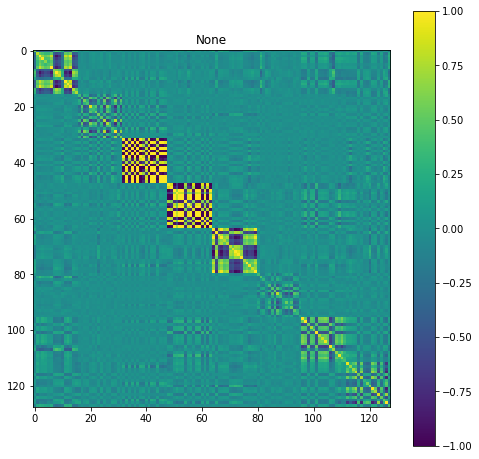

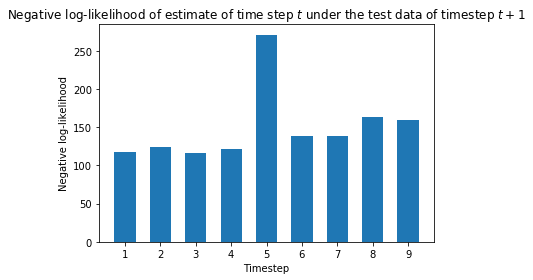

NLL for next time step = 149.950076089


In [57]:
vis_utils.plot_cov_matrix(csig_covs[0])
vis_utils.plot_for_next_timestep(data=Y, covs=csig_covs);

In [58]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=csig_covs))

Final NLL = 142.05298357


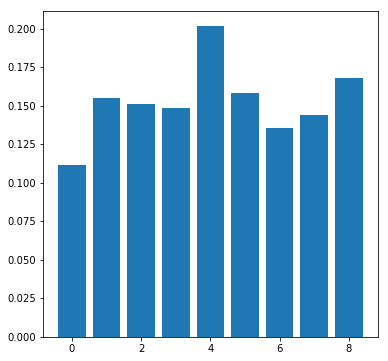

0.152600540152


In [59]:
print calc_reg_term(csig_covs)

In [60]:
print np.mean(np.abs(csig.ws[2].get_value()))

0.0919885215861


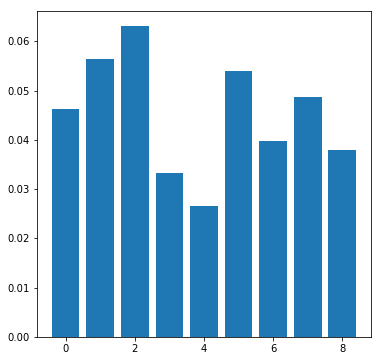

0.045123721077059198

In [61]:
calc_reg_term([x.get_value() for x in csig.ws])

# Diagonal matrix

In [112]:
diag_covs = []
for x in X:
    diag_covs.append(np.diag(np.var(x, axis=0)))

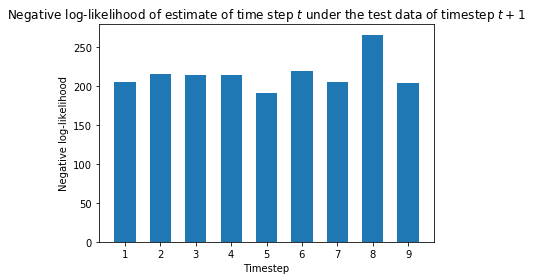

NLL for next time step = 214.897157782


In [113]:
vis_utils.plot_for_next_timestep(data=Y, covs=diag_covs);

In [114]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=diag_covs))

Final NLL = 215.091698358


In [115]:
vis_utils.plot_cov_matrix(diag_covs)

TypeError: Invalid dimensions for image data

## Ledoit-Wolf Estimation

In [ ]:
lw_covs = []
for x in X:
    lw_est = skcov.LedoitWolf()
    lw_est.fit(x)
    lw_covs.append(lw_est.covariance_)

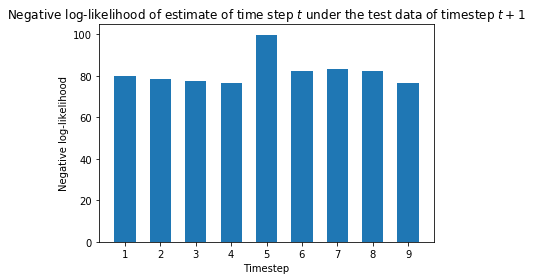

NLL for next time step = 81.8690013507


In [172]:
vis_utils.plot_for_next_timestep(data=Y, covs=lw_covs);

In [174]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=lw_covs))

Final NLL = 79.6438983768


## Oracle Approximating Shrinkage

In [26]:
oas_covs = []
for x in X:
    oas_est = skcov.OAS()
    oas_est.fit(x)
    oas_covs.append(oas_est.covariance_)

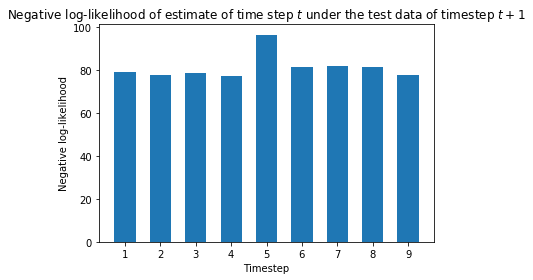

NLL for next time step = 81.2078545074


In [175]:
vis_utils.plot_for_next_timestep(data=Y, covs=oas_covs);

In [176]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=oas_covs))

Final NLL = 79.3443047261


# PCA

In [204]:
pca_covs = []
for x in X:
    pca_est = PCA(n_components=m)
    pca_est.fit(x)
    pca_covs.append(pca_est.get_covariance())

In [205]:
vis_utils.plot_for_next_timestep(data=Y, covs=pca_covs);

LinAlgError: singular matrix

In [207]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=pca_covs))

LinAlgError: singular matrix

# Factor Analysis

In [91]:
factor_covs = []
for x in X:
    factor_est = FactorAnalysis(n_components=m)
    factor_est.fit(x)
    factor_covs.append(factor_est.get_covariance())

In [92]:
# factor_covs = [x + 1e-6 * np.eye(nv) for x in factor_covs]

In [177]:
vis_utils.plot_for_next_timestep(data=Y, covs=factor_covs);

LinAlgError: singular matrix

In [178]:
print "Final NLL = {}".format(matric_utils.calculate_nll_score(data=Y, covs=factor_covs))

NameError: name 'calculate_nll_score' is not defined

## Graphical LASSO

In [90]:
glasso_covs = []
for x in X:
    glasso_est = skcov.GraphLasso()
    glasso_est.fit(x)
    glasso_covs.append(glasso_est.covariance_)

FloatingPointError: Non SPD result: the system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

In [179]:
vis_utils.plot_for_next_timestep(data=Y, covs=glasso_covs);

IndexError: list index out of range

In [183]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=glasso_covs))

IndexError: list index out of range

# Time Varying Graphical Lasso

In [25]:
sys.path.append('../TVGL/')
from TVGL import TVGL

In [28]:
cur_data = []
for x in X:
    cur_data += list(x)
cur_data = np.array(cur_data)

In [106]:
tvgl_covs = TVGL(data=cur_data,
                lengthOfSlice=train_cnt,
                lamb=0.1,
                beta=1000,
                indexOfPenalty=1,
                verbose=True,
                max_iter=80)

Use l-1 penalty function
10
lambda = 0.1, beta = 1000
Distributed ADMM (4 processors)
Iteration 1
  r: 3.76502798286
  e_pri: 0.321983922909
  s: 57.5292610957
  e_dual: 0.485848717663
Iteration 2
  r: 5.59116599111
  e_pri: 0.342054396875
  s: 33.6523393245
  e_dual: 0.492844170447
Iteration 3
  r: 5.87751291984
  e_pri: 0.356138690936
  s: 24.007059826
  e_dual: 0.499761215887
Iteration 4
  r: 5.09474304521
  e_pri: 0.366848468002
  s: 18.8101087015
  e_dual: 0.505185218535
Iteration 5
  r: 4.29231654194
  e_pri: 0.375741867296
  s: 15.6615434959
  e_dual: 0.509265267696
Iteration 6
  r: 3.71575992558
  e_pri: 0.38342754699
  s: 13.4766231638
  e_dual: 0.512364294564
Iteration 7
  r: 3.35859267789
  e_pri: 0.390210129356
  s: 11.8461629772
  e_dual: 0.51483214873
Iteration 8
  r: 3.1163613209
  e_pri: 0.396270331888
  s: 10.5730091183
  e_dual: 0.516904772173
Iteration 9
  r: 2.92517043092
  e_pri: 0.401734781062
  s: 9.54973332853
  e_dual: 0.518714487757
Iteration 10
  r: 2.7624330

In [107]:
tvgl_covs=[np.linalg.inv(x) for x in tvgl_covs]

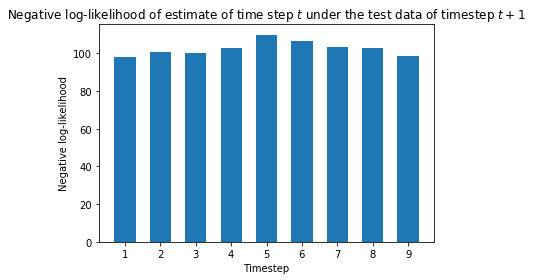

NLL for next time step = 102.659240168


In [108]:
vis_utils.plot_for_next_timestep(data=Y, covs=tvgl_covs);

In [109]:
print "Final NLL = {}".format(metric_utils.calculate_nll_score(data=Y, covs=tvgl_covs))

Final NLL = 101.788591261


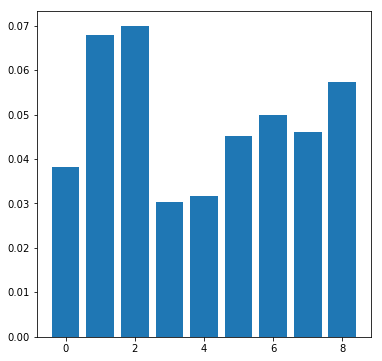

0.0485144998727


In [110]:
print calc_reg_term(tvgl_covs)